In [1]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from func import load_model, save_model, mse_loss
from keras.models import model_from_json
import h5py
from joblib import dump, load

2024-06-16 11:12:31.318272: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 11:12:31.567402: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#load the models
#autoencoder = load_model('model_directorynew_try')
#autoencoder_std = load_model('model_directorystd_dae.h5')
model = load('isolation_forest_model.joblib')

In [3]:
with h5py.File("extended_signal_data.h5", 'r') as file:
    signal =  np.array(np.transpose(file['extended_sig']))
    
signal_labels = ['extended_sig']

## DAE

In [4]:
#load data
with h5py.File('correct_inputs_node_56.h5', 'r') as file:
    X_test = np.array(file['BKG_input'])
    bkg_prediction = np.array(file['BKG_predicted'])
    signal_data = np.array(file['sig_input'])
    signal_prediction = np.array(file['sig_predicted'])

In [5]:
signal_results = []

signal_results.append([signal_labels, signal_data, signal_prediction])

In [6]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2].astype(np.float32)).numpy())

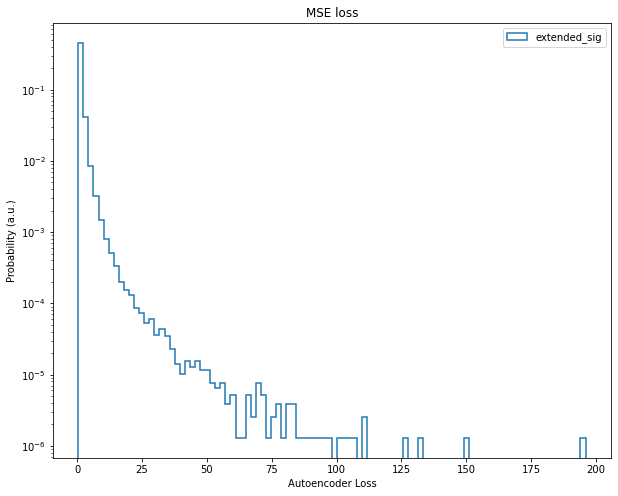

In [7]:
bin_size=100

plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.savefig("First training_16_8_nodes")
plt.show()

## DAE with standardized input

In [7]:
#load data
with h5py.File('std_dae_data.h5', 'r') as file:
    X_test_std = np.array(file['BKG_input'])
    bkg_prediction_std = np.array(file['BKG_predicted'])
    signal_data_std = np.array(file['sig_input'])
    signal_prediction_std = np.array(file['sig_predicted'])

In [8]:
signal_results_std = []

signal_results_std.append([signal_labels, signal_data_std, signal_prediction_std])

In [9]:
# compute loss value (true, predicted)
total_loss_std = []
total_loss_std.append(mse_loss(X_test_std, bkg_prediction_std.astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data_std):
    total_loss_std.append(mse_loss(signal_X, signal_results_std[i][2].astype(np.float32)).numpy())

In [ ]:
bin_size=100

plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss_std[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.savefig("dae_std_loss.pnd")
plt.show()

## Isolation Forest

In [7]:
score_xtest = model.predict(X_test, output='score')
score_signal = model.predict(signal, output='score')

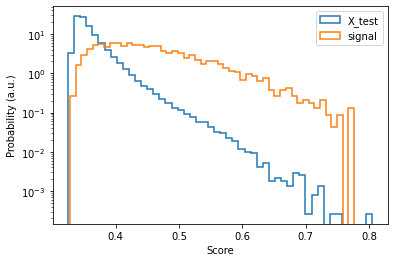

In [13]:
plt.figure()
for score, label in zip([score_xtest, score_signal], ["X_test", "signal"]):
     plt.hist(score, bins=50, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Score")
plt.ylabel("Probability (a.u.)")
plt.legend(loc='best')
#plt.savefig("First training_16_8_nodes")
plt.show()

## Boosted Isolation Forest

In [8]:
boosted_forest = load('boosted_isolation_forest.joblib')

In [9]:
#import the data
filename = 'final_boosted_bkg.h5'

with h5py.File(filename, 'r') as file:
    X_train_boosted = np.array(file['X_train'])
    X_test_boosted = np.array(file['X_test'])
    X_val_boosted = np.array(file['X_val'])
    
with h5py.File("extended_boosted_sig.h5", 'r') as file:
    signal_boosted =  np.array(np.transpose(file['boosted_sig']))

In [10]:
score_xtest_boosted = boosted_forest.predict(X_test_boosted, output='score')
score_signal_boosted = boosted_forest.predict(signal_boosted, output='score')

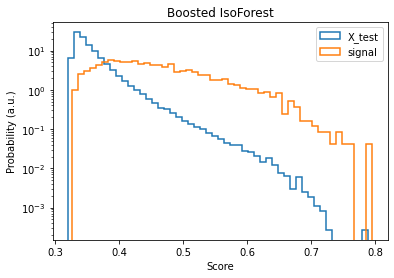

In [13]:
plt.figure()
for score, label in zip([score_xtest_boosted, score_signal_boosted], ["X_test", "signal"]):
     plt.hist(score, bins=50, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.title("Boosted IsoForest")
plt.xlabel("Score")
plt.ylabel("Probability (a.u.)")
plt.legend(loc='best')
plt.show()

### Second try for boosted forest

In [11]:
boosted_forest_2 = load('boosted_isolation_forest_2.joblib')

In [12]:
#import the data
filename = 'boosted_bkg_2.h5'

with h5py.File(filename, 'r') as file:
    X_train_boosted_2 = np.array(file['X_train'])
    X_test_boosted_2 = np.array(file['X_test'])
    X_val_boosted_2 = np.array(file['X_val'])
    
with h5py.File("boosted_sig_2.h5", 'r') as file:
    signal_boosted_2 =  np.array(np.transpose(file['boosted_sig_2']))

In [13]:
score_xtest_boosted_2 = boosted_forest_2.predict(X_test_boosted_2, output='score')
score_signal_boosted_2 = boosted_forest_2.predict(signal_boosted_2, output='score')

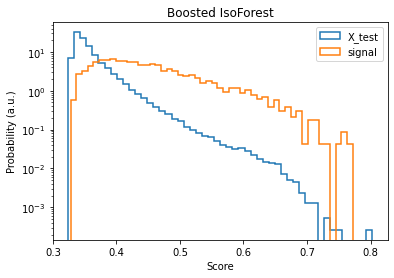

In [17]:
plt.figure()
for score, label in zip([score_xtest_boosted_2, score_signal_boosted_2], ["X_test", "signal"]):
     plt.hist(score, bins=50, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.title("Boosted IsoForest")
plt.xlabel("Score")
plt.ylabel("Probability (a.u.)")
plt.legend(loc='best')
plt.show()

### third try

In [14]:
boosted_forest_3 = load('isolation_forest_with_param_3.joblib')

In [15]:
#import the data
filename = 'bkg_w_3.h5'

with h5py.File(filename, 'r') as file:
    X_train_boosted_3 = np.array(file['X_train'])
    X_test_boosted_3 = np.array(file['X_test'])
    X_val_boosted_3 = np.array(file['X_val'])
    
with h5py.File("sig_w_param.h5", 'r') as file:
    signal_boosted_3 =  np.array(np.transpose(file['sig_with_param_3']))

In [16]:
score_xtest_boosted_3 = boosted_forest_3.predict(X_test_boosted_3, output='score')
score_signal_boosted_3 = boosted_forest_3.predict(signal_boosted_3, output='score')

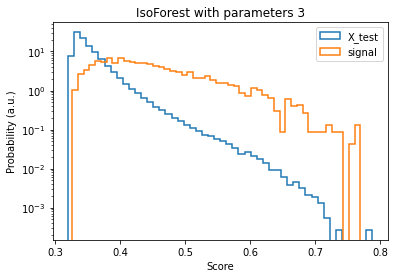

In [20]:
plt.figure()
for score, label in zip([score_xtest_boosted_3, score_signal_boosted_3], ["X_test", "signal"]):
     plt.hist(score, bins=50, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.title("IsoForest with parameters 3")
plt.xlabel("Score")
plt.ylabel("Probability (a.u.)")
plt.legend(loc='best')
plt.savefig("loss_boosted_3")
plt.show()

### Setup for ROC

In [17]:
# Create labels for the test and signal data

y_test = np.zeros(X_test.shape[0])
y_signal = np.ones(signal.shape[0])

# Combine the scores and the labels
scores = np.concatenate([score_xtest, score_signal])
y_true = np.concatenate([y_test, y_signal])

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, scores)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

In [18]:
#boosted forest

# Create labels for the test and signal data

y_test_boosted = np.zeros(X_test_boosted.shape[0])
y_signal_boosted = np.ones(signal_boosted.shape[0])

# Combine the scores and the labels
scores_boosted = np.concatenate([score_xtest_boosted, score_signal_boosted])
y_true_boosted = np.concatenate([y_test_boosted, y_signal_boosted])

# Calculate the ROC curve
fpr_boosted, tpr_boosted, thresholds_boosted = roc_curve(y_true_boosted, scores_boosted)

# Calculate the AUC
roc_auc_boosted = auc(fpr_boosted, tpr_boosted)

In [19]:
#second boosted forest

# Create labels for the test and signal data

y_test_boosted_2 = np.zeros(X_test_boosted_2.shape[0])
y_signal_boosted_2 = np.ones(signal_boosted_2.shape[0])

# Combine the scores and the labels
scores_boosted_2 = np.concatenate([score_xtest_boosted_2, score_signal_boosted_2])
y_true_boosted_2 = np.concatenate([y_test_boosted_2, y_signal_boosted_2])

# Calculate the ROC curve
fpr_boosted_2, tpr_boosted_2, thresholds_boosted_2 = roc_curve(y_true_boosted_2, scores_boosted_2)

# Calculate the AUC
roc_auc_boosted_2 = auc(fpr_boosted_2, tpr_boosted_2)

In [20]:
#third boosted forest

# Create labels for the test and signal data

y_test_boosted_3 = np.zeros(X_test_boosted_3.shape[0])
y_signal_boosted_3 = np.ones(signal_boosted_3.shape[0])

# Combine the scores and the labels
scores_boosted_3 = np.concatenate([score_xtest_boosted_3, score_signal_boosted_3])
y_true_boosted_3 = np.concatenate([y_test_boosted_3, y_signal_boosted_3])

# Calculate the ROC curve
fpr_boosted_3, tpr_boosted_3, thresholds_boosted_3 = roc_curve(y_true_boosted_3, scores_boosted_3)

# Calculate the AUC
roc_auc_boosted_3 = auc(fpr_boosted_3, tpr_boosted_3)

In [21]:
#set up dae

target_background = np.zeros(total_loss[0].shape[0])

In [22]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

In [27]:
#dae std input

target_background_std = np.zeros(total_loss_std[0].shape[0])

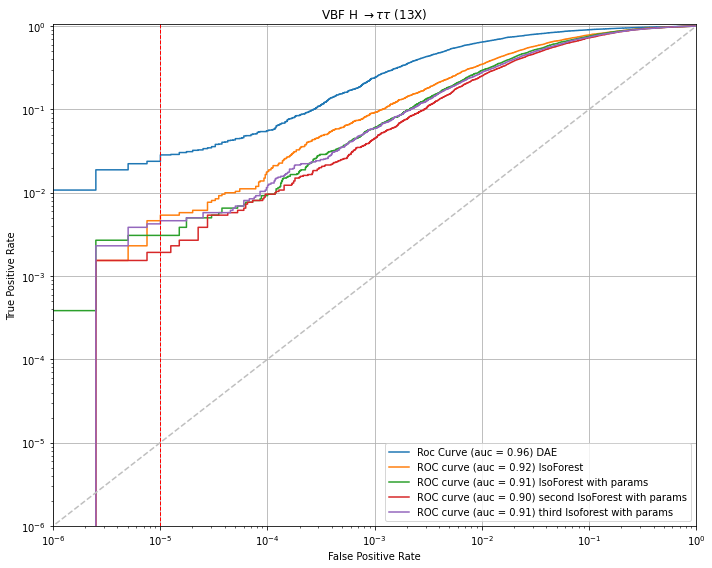

In [23]:
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='Roc Curve (auc = %0.2f) DAE'%auc_loss, linewidth=1.5) #DAE Roc

    
    #trueVal_std = np.concatenate((np.ones(total_loss_std[i].shape[0]), target_background_std)) # anomaly=1, bkg=0
    #predVal_loss_std = np.concatenate((total_loss_std[i], total_loss_std[0]))

    #fpr_loss_std, tpr_loss_std, threshold_loss_std = roc_curve(trueVal_std, predVal_loss_std)

    #auc_loss_std = auc(fpr_loss_std, tpr_loss_std)
    
    #plt.plot(fpr_loss_std, tpr_loss_std, "-", label='ROC curve (auc = %0.2f) standardised DAE'%auc_loss_std, linewidth=1.5) #DAE Roc
    
    
plt.plot(fpr, tpr, "-", lw=1.5, label= 'ROC curve (auc = %0.2f) IsoForest' % roc_auc) #IsoForest roc
plt.plot(fpr_boosted, tpr_boosted, "-", lw=1.5, label= 'ROC curve (auc = %0.2f) IsoForest with params' % roc_auc_boosted) # boosted IsoForest roc
plt.plot(fpr_boosted_2, tpr_boosted_2, "-", lw=1.5, label= 'ROC curve (auc = %0.2f) second IsoForest with params' % roc_auc_boosted_2) # second boosted IsoForest roc
plt.plot(fpr_boosted_3, tpr_boosted_3, "-", lw=1.5, label= 'ROC curve (auc = %0.2f) third Isoforest with params' % roc_auc_boosted_3) # third boosted IsoForest roc
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title(r'VBF H $\rightarrow \tau \tau$ (13X)')
plt.xlim([10**(-6), 1])
plt.ylim([10**(-6), 1.05])
plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout() 
plt.savefig("ROC_combined.png")
plt.show()